In [1]:
import numpy as np
from scipy.stats.stats import pearsonr
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.time import Time

from os.path import exists 
from GPbaseband1 import *
%pylab inline
#Using latex rendering:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)



/opt/python/2.7.10/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['size']
`%matplotlib` prevents importing * from pylab and numpy


In [2]:
with open('interpulses.txt', 'r') as f:
    text = f.read()
    interpulses = text.split('\n')
    
with open('mainpulses.txt', 'r') as f:
    text = f.read()
    mainpulses = text.split('\n')

In [3]:
time_string1 = '2015-10-19T00:17:47.415' # S/N = 89!, main pulse 
time_string2 = '2015-10-19T02:35:26.143' # S/N = 43, main pulse 
time_string3 = '2015-10-19T02:06:52.280' #S/N = 7.9, inter pulse
time_string4 = '2015-10-19T02:06:58.031' #S/N = 9.6, main pulse, also a double pulse
time_string5 = '2015-10-19T00:55:15.557' #S/N = 8.33, main pulse
time_string6 = '2015-10-19T00:55:49.673' #S/N = 8.55, main pulse
time_string7 = '2015-10-19T01:29:52.509' #S/N = 8.44, main pulse
time_string8 = '2015-10-19T01:55:06.340' #S/N = 8.66, main pulse
time_string9 = '2015-10-19T02:13:46.551' #S/N = 9.56, main pulse
time_string10 = '2015-10-19T02:36:11.418'#S/N = 8.41, main pulse

time_string11 = '2015-10-19T00:54:59.880' # bright double pulse
time_string12 = '2015-10-19T02:36:46.815'  #bright double pulse2

time_string13 = '2015-10-19T00:37:14.418' # close main pulse pair
time_string14 = '2015-10-19T00:37:15.126'

time_string15 = '2015-10-19T01:57:05.107' # the closest main pulse pair 
time_string16 = '2015-10-19T01:57:05.410'

time_string17 = '2015-10-19T00:56:55.579' # close pair by 1.078s
time_string18 = '2015-10-19T00:56:54.501' 

time_string19 = '2015-10-19T02:17:06.664' #close pair by 1.281s
time_string20 = '2015-10-19T02:17:07.945' 

time_string21 = '2015-10-19T01:28:04.429' #close pair by 1.65
time_string22 = '2015-10-19T01:28:06.081' 

time_string23 = '2015-10-19T01:44:15.701' # close pair by 1.98
time_string24 = '2015-10-19T01:44:17.690' 

time_string25 = '2015-10-19T01:29:52.509' # close main pulse pair by 2.09
time_string26 = '2015-10-19T01:29:54.600' 

time_string27 = '2015-10-18T23:47:20.315' # close interpulse and main pulse pair (interpulse) by 0.49s
time_string28 = '2015-10-18T23:47:20.807' #main pulse for the above pair 

7.57612653424


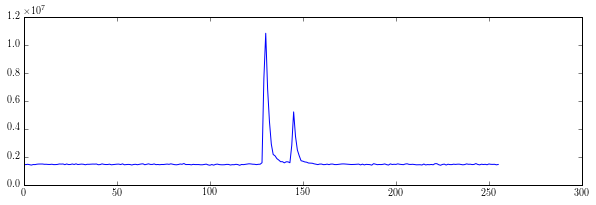

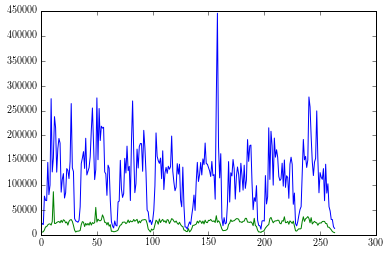

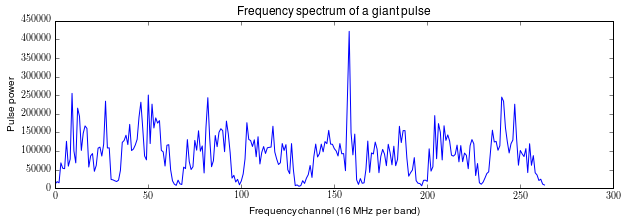

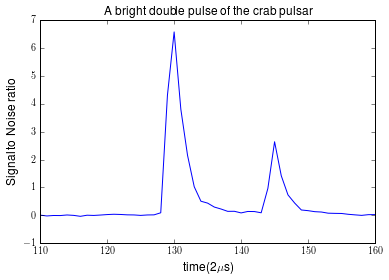

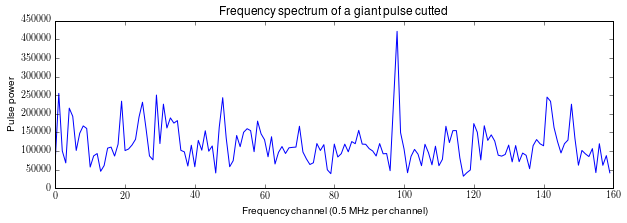

In [4]:
def get_SN(outputsumfreq):
    noise_std = np.std(outputsumfreq[:5]) 
    noise_mean = np.mean(outputsumfreq[:5])
    sigs_noise = (outputsumfreq-noise_mean)/noise_mean
    return sigs_noise

lower = 130
upper = 450
def process_freq_spec(gp1,nchan,draw=0):
    '''function takes a continuous frequency spectrum and cuts it into 8 bands, 
    then stitch the 8 bands together to compute a correlation coefficient. 
    function also plots the frequency spectrum if draw = 1'''
    gp1_8=np.array([gp1[int(lower/512.*nchan):int(upper/512.*nchan)]])
    for j in range(7):gp1_8=np.append(gp1_8,np.array([gp1[(j+1)*(nchan+1)+int(lower/512.*nchan):(j+1)*(nchan+1)+int(upper/512.*nchan)]]),0)    
    if nchan == 512:
        new1 = np.zeros((8,25))
        for i in range(8):
            for j in range(25):
                new1[i,j] = average(gp1_8[i,j*N:(j+1)*N])
        if draw:
            figure()
            plot(new1.ravel())
        return new1.ravel(),gp1_8.ravel()
    else:
        if draw:
            figure(figsize = (10,3))
            plot(gp1_8.ravel())
            xlabel('Frequency channel (0.5 MHz per channel)')
            ylabel('Pulse power')
            title('Frequency spectrum of a giant pulse cutted')
        return gp1_8.ravel(),0

def load_gp(time_string,nchan,draw = 0):
    '''Takes in a time string, a string indicating whcih telescope to use, and an interger of nchan'''
#     output = np.load('./GPs/p{}.npy'.format(time_string))
    output = np.load('/mnt/raid-cita/xzxu/GPs/GPp1-{}/p{}.npy'.format(nchan,time_string))

    outputsumfreq = output.sum(0) 
    #computes signal to noise after summing all the frequencies
    sigs_noise = get_SN(outputsumfreq)
    
    peak_time = np.argmax(sigs_noise)
    S_N = outputsumfreq[peak_time]/np.mean(outputsumfreq[:5])
    

    if nchan == 512:
        background_std = []
        for j in range(8):
            background_std.append(output[j*(nchan+1)+lower/512.*nchan:j*(nchan+1)+upper/512.*nchan,:peak_time-3].std())
        output_pulse = output[:,peak_time]
#         print 'std2 =',background_std2
        background_freq = output[:,peak_time-3]

    if nchan == 128:
        sn_sorted = np.argsort(sigs_noise)
#         print sn_sorted
#         print sn_sorted.shape
        background_freq = (output[:,sn_sorted[30]]+output[:,sn_sorted[31]])/2
        output_pulse = (output[:,sn_sorted[-1]]+output[:,sn_sorted[-2]])/2
        background_std = []
        for j in range(8):
            background_std.append(background_freq[j*(nchan+1)+lower/512.*nchan:j*(nchan+1)+upper/512.*nchan].std())
            
    if nchan == 32:
        sn_sorted = np.argsort(sigs_noise)
#         background_freq = np.concatenate([np.array([output[:,sn_sorted[-k]]]) for k in range(50,55)],axis = 0).sum(0) 
        background_freq = output[:,31:35].sum(1)
        output_pulse = np.concatenate([np.array([output[:,sn_sorted[-k]]]) for k in range(1,5)],axis = 0).sum(0)
#         background_1 = output[:,sn_sorted[-51]]
#         output_pulse = output[:,sn_sorted[-1]]
        background_c = background_freq[int(lower/512.*nchan):int(upper/512.*nchan)]
        for j in range(1,8):
            background_c = np.concatenate((background_c,background_freq[int(j*(nchan+1)+lower/512.*nchan):int(j*(nchan+1)+upper/512.*nchan)]),axis = 0)
        background_std = np.std(background_c.ravel())
#         figure()
#         plot(background_c.ravel())
        
    if nchan == 16:
        sn_sorted = np.argsort(sigs_noise)
#         print sn_sorted
        background_1= np.concatenate([np.array([output[:,sn_sorted[-k]]]) for k in range(51,56)],axis = 0).sum(0) 
        output_pulse = np.concatenate([np.array([output[:,sn_sorted[-k]]]) for k in range(1,6)],axis = 0).sum(0)
#         background_1 = output[:,sn_sorted[-101]]
#         output_pulse = output[:,sn_sorted[-1]]
        background_std = np.std(background_1)
        background_freq = background_1
        
    freq_spec = output_pulse-background_freq
#     freq_spec = output_pulse
    
    
    if draw:
        figure(figsize = (10,3))
        plot(outputsumfreq)
        figure()
        plot(output_pulse)
        plot(background_freq)
        figure(figsize = (10,3))
        plot(freq_spec)
        xlabel('Frequency channel (16 MHz per band)')
        ylabel('Pulse power')
        title('Frequency spectrum of a giant pulse')
    return freq_spec,background_std,sigs_noise, S_N


nchan = 32

N = 16
time_string = time_string11
fs1,bgstd1,os1,sn1 = load_gp(time_string,nchan,draw = 1)
# fs2,bgstd2,os2,sn2 = load_gp(time_string,nchan,draw = 1)

figure()
plot(os1)
xlabel('time(2$\mu$s)',fontsize = 12)
ylabel('Signal to Noise ratio',fontsize = 12)
title('A bright double pulse of the crab pulsar')
xlim(110,160)
print sn1
fgp1n,fgp1 = process_freq_spec(fs1,nchan,draw = 1)
# fgp2n,fgp2 = process_freq_spec(fs2,nchan,draw = 1)


In [6]:
def get_cc((fs1,bgstd1),(fs2,bgstd2)):
# def get_cc(fs1,fs2):
    mean1 = np.mean(fs1)
    mean2 = np.mean(fs2)
    numerator = np.mean((fs1-mean1)*(fs2-mean2))
    denominator = np.sqrt((np.std(fs1)**2-bgstd1**2)*(np.std(fs2)**2-bgstd2**2))
#     denominator = np.std(fs1)*np.std(fs2)
    return numerator/denominator
    
def get_ccs((fs1,bgstd1),(fs2,bgstd2)):
    coefficients= []
    for i in range(8):
        X = fs1[i]
        Y = fs2[i]
        Xbg = bgstd1[i]
        Ybg = bgstd2[i]
        coefficient = get_cc((X,Xbg),(Y,Ybg))
        coefficients.append(coefficient) 
    return np.mean(coefficients),coefficients

# get_cc(fgp1n,fgp2n)
get_cc((fgp1n,bgstd1),(fgp2n,bgstd2))

NameError: name 'fgp2n' is not defined

In [7]:
colors = [(31, 119, 180),(255, 127, 14), (44, 160, 44),(148, 103, 189),(214, 39, 40)] #blue, orange, green, purple, red
for i in range(len(colors)):    
    r, g, b = colors[i]    
    colors[i] = (r / 255., g / 255., b / 255.) 

In [33]:
nchan = 32
N = 425/25 #N is how many points I average into 1 in process frequency function. 
ctvalues = np.zeros(shape = (0,2))
for i,time_string1 in enumerate(interpulses[:-1]):
    t_gp1 = Time(time_string1)
#     if exists('/home/ramain/GPs/GP{}/p{}.npy'.format('p',time_string1)): 
    if exists('/mnt/raid-cita/xzxu/GPs/GPp1-{}/p{}.npy'.format(nchan,time_string1)):
        fs1,bgstd1,os1,sn1 = load_gp(time_string1,nchan)
        if sn1<1.5:
            continue
        for j,time_string2 in enumerate(interpulses[i+1:-1]):
            t_gp2 = Time(time_string2)
            dt = t_gp2-t_gp1
            if abs(dt.sec)<1000:
                if abs(dt.sec)<1e-2:
                    print time_string1,time_string2
                if exists('/mnt/raid-cita/xzxu/GPs/GPp1-{}/p{}.npy'.format(nchan,time_string2)):
                    fs2,bgstd2,os2,sn2 = load_gp(time_string2,nchan)
                    if sn2<1.5:
                        continue 
                    fgp1,_ = process_freq_spec(fs1,nchan,draw = 0)
                    fgp2,_ = process_freq_spec(fs2,nchan,draw = 0)
#                     cc=get_cc(fgp1,fgp2)
                    cc = get_cc((fgp1,bgstd1),(fgp2,bgstd2))
                    ctvalues=np.append(ctvalues,np.array([[cc,abs(dt.sec)]]),axis = 0)

np.save('./figures/correlation_coeff/ctvalues_aug11_MP-IP-32-n.npy',ctvalues)


/opt/python/2.7.10/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in divide


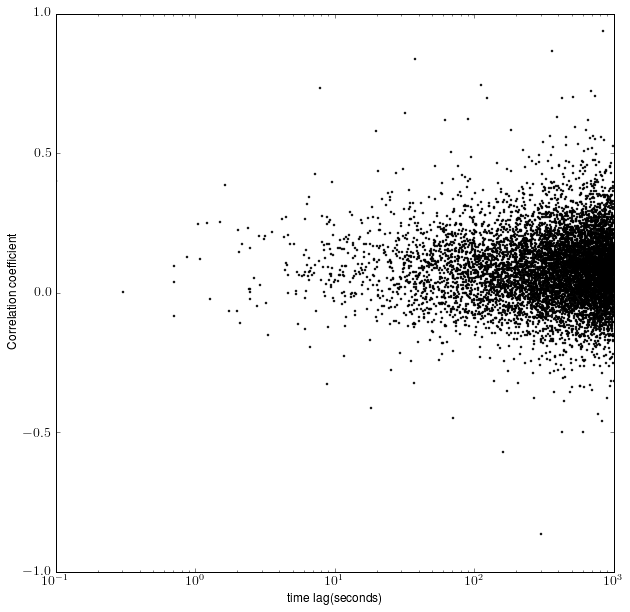

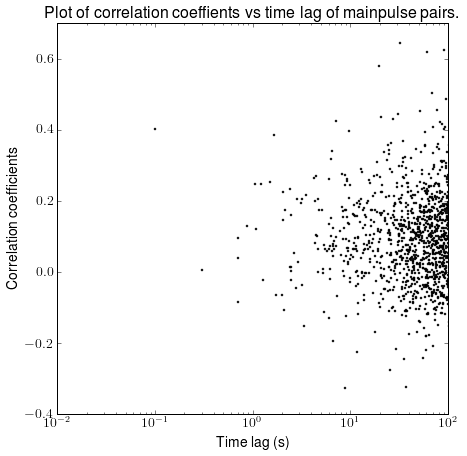

In [38]:
ctvalues = np.load('./figures/correlation_coeff/ctvalues_aug11_MP-MP-32-n.npy')
# np.save('./figures/correlation_coeff/{}_{}ctvaluesef_jul5.npy'.format(text_name,nchan),ctvalues)

figure(figsize = (10,10))
semilogx(ctvalues[:,1],ctvalues[:,0],'ok',markersize = 2)
xlabel('time lag(seconds)',fontsize = 12)
ylim(-1.,1)
ylabel('Correlation coefficient',fontsize = 12)
tick_params(axis='both', which='major', labelsize=14)

bin_no = 10
time_values = ctvalues[:,1]
cvalues = ctvalues[:,0]
time_values[np.isnan(cvalues)]=0
cvalues[np.isnan(cvalues)]=0
bins = np.logspace(-6,3,bin_no)
bin_means = np.histogram(time_values,bins,weights = cvalues,density = False)[0]/np.histogram(time_values,bins,density = False)[0]

figure(figsize = (7,7))
# semilogx((bins[:-1]+bins[1:])/2,bin_means,'-',label = 'averaged data points'.format(bin_no))
semilogx(time_values,cvalues,'ok',markersize = 2,label = 'correlation coefficients of MP-MP pairs')
# legend()
title('Plot of correlation coeffients vs time lag of mainpulse pairs.'.format(nchan),fontsize = 16)
xlabel('Time lag (s)',fontsize = 14)
ylim(-.4,.7)
xlim(0.01,100)
ylabel('Correlation coefficients',fontsize=14)
tick_params(axis='both', which='major', labelsize=14)


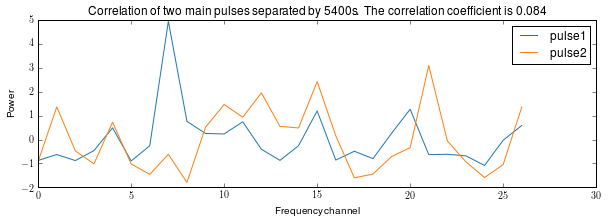

In [8]:
figure(figsize = (10,3))
plot(fgp1[0]/fgp1[0].mean()-1.,label = 'pulse1',color = colors[0])
plot(fgp2[0]/fgp2[0].mean()-1.,label = 'pulse2',color = colors[1])
# plot(fgp3[0]/fgp3[0].mean()-1.,label = 'jb',color = colors[2])
legend()
# title('Correlation of a pulse at wb(S/N = {}), ef(S/N = {}) and jb(S/N = {}). \n The correlation coefficient calculated for the 1st band is {}(ef-jb), {}(ef-wb), {}(wb-jb)'.format(round(sn1,3),round(sn2,3),round(sn3,3),round(ccs23[0],3),round(ccs12[0],3),round(ccs13[0],3)))
title('Correlation of two main pulses separated by 5400s. The correlation coefficient is {}'.format(round(ccs[0],3)))
xlabel('Frequency channel')
ylabel('Power')

In [7]:
t_dp1 = '2015-10-19T02:06:58.031' # double pulse
t_dp2 = '2015-10-19T00:54:59.880' # bright double pulse
t_dp3 = '2015-10-19T02:36:46.815'# bright double pulse2

In [8]:
def get_output_from_dchan(gp1s,nchan):
    gp1t = np.fft.irfft(gp1s,axis=1)
    gp1s = gp1t.reshape(-1,2*nchan,16)
    gp1s = np.fft.rfft(gp1s,axis=1)
    dchan = gp1s
    dR = np.concatenate((dchan[:,::-1,8], dchan[...,0], dchan[:,::-1,10], dchan[...,2], dchan[:,::-1,12], dchan[...,4], dchan[:,::-1,14], dchan[...,6]), axis=1)
    dL = np.concatenate((dchan[:,::-1,9], dchan[...,1], dchan[:,::-1,11], dchan[...,3], dchan[:,::-1,13], dchan[...,5], dchan[:,::-1,15], dchan[...,7]), axis=1)
    output = (abs(dR)**2 + abs(dL)**2).T
    return output

In [73]:
nchan

32

(64, 129, 16)
(64, 129, 16)
(264, 256)


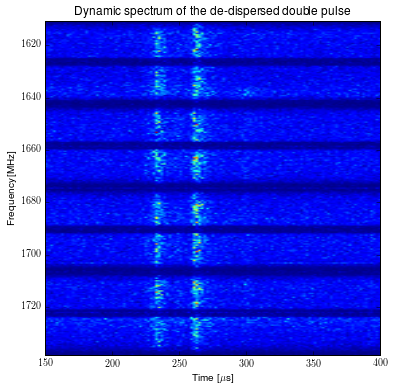

In [80]:
output = np.load('/mnt/raid-cita/xzxu/GPs/GPp1-{}/p{}.npy'.format(nchan,t_dp3))
output1 = np.load('/mnt/raid-cita/xzxu/GPs/GPef/p{}.npy'.format(t_dp3))
output2 = np.load('/mnt/raid-cita/xzxu/GPs/GPjb/p{}.npy'.format(t_dp3))
print output1.shape
print output2.shape
output1 = get_output_from_dchan(output1,nchan)
output2 = get_output_from_dchan(output2,nchan)
figure(figsize = (6,6))
imshow(output,aspect = 'auto',extent=(0,256*2,1610.49+16*8,1610.49))
title('Dynamic spectrum of the de-dispersed double pulse')
xlabel('Time [$\mu$s]')
ylabel('Frequency [MHz]')
xlim(150,400)
print output.shape
# xlabel(time(microseconds))
# ylabel(Frequency)

2.64595730884
[ 31 242  11 251 198  42  82 244  59  13  41 230  49 208 169  62 179  64
 232 245 203 207  66  91 159 192 214 185  27  35  16  56  20 243 108 210
  98 104  37   2 219 217 200  10 199  47 101  73 162 177 204  29  34  83
 187 252  45 241  46  75  90  63 247  78 191 253  25 100  80  79 205  93
 103 233 221 168  86  65 222 237   1  72 213 186 224  21  44 248  40  39
 175 226 173  22 254 240  32  28 239   7  14 190 206  24  52   6  30  36
 174 234  92 154 231 255  99  71 105   3 215 164  48 161 182  87 180 211
 176  77  55 194   0  89 163 195  50  61 235  26   4 160 197 170 167 110
 109 181  97 250 229  81 102 227 143 107  76 216 209  96  33   8 246 157
  53  54  67  85 155 193  17  70 188  57  84 228 202 201 223 178 238 220
  95  38 156  51 146  58 153 189 166  74  68 212 184  19 236 158  15  94
 196 172  43  23 249  12 225  60 165 171  18 144   5   9 111 147  88 183
 106  69 218 145 142 152 141 140 139 127 148 151 128 122 126 138 149 112
 137 150 121 113 125 123 136 124 120 

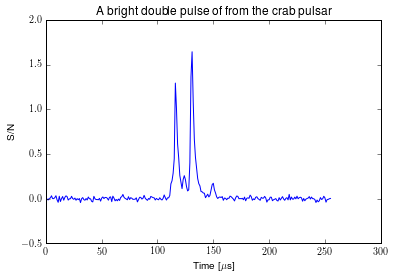

In [82]:
outputsumfreq = output.sum(0) 
#computes signal to noise after summing all the frequencies
sigs_noise = get_SN(outputsumfreq)

peak_time = np.argmax(sigs_noise)
S_N = outputsumfreq[peak_time]/np.mean(outputsumfreq[:5])

sn_sorted = np.argsort(sigs_noise)
print S_N 
print sn_sorted
plot(sigs_noise)
# xlim(200,350)
xlabel('Time [$\mu$s]')
ylabel('S/N')
title('A bright double pulse of from the crab pulsar')



0.191654162275


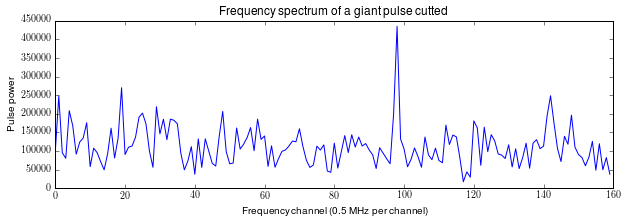

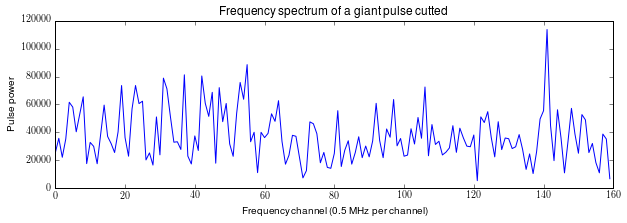

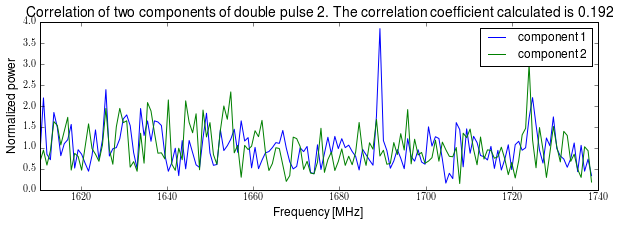

In [79]:
background_freq1= output[:,31:35].sum(1)
background_freq2 = output[:,31:35].sum(1)
output_pulse1 = output[:,129:133].sum(1) -background_freq1
output_pulse2 = output[:,144:148].sum(1) -background_freq2

# background_c = background_freq1[lower/512.*nchan:upper/512.*nchan]
# for j in range(1,8):
#     background_c = np.concatenate((background_c,background_freq1[j*(nchan+1)+lower/512.*nchan:j*(nchan+1)+upper/512.*nchan]),axis = 0)
background_std1 = np.std(background_freq1)
background_std2 = np.std(background_freq2)
fgp1,_ = process_freq_spec(output_pulse1,nchan,draw = 1)
fgp2,_ = process_freq_spec(output_pulse2,nchan,draw = 1)

cc = get_cc((fgp1,background_std1),(fgp2,background_std2))
print cc
figure(figsize = (10,3))
# plot(np.linspace(1610.5,1610.5+16*8,len(fgp1)),fgp1/np.mean(fgp1),label = 'ef')
# plot(np.linspace(1610.5,1610.5+16*8,len(fgp2)),fgp2/np.mean(fgp2),label = 'jb')
plot(np.linspace(1610.5,1610.5+16*8,len(fgp1)),fgp1/fgp1.mean(),label = 'component 1')
plot(np.linspace(1610.5,1610.5+16*8,len(fgp2)),fgp2/fgp2.mean(),label = 'component 2')
# title('The first component of double pulse 2 at Effelsberg and Jordrell Bank. \n The correlation coefficient calculated is {}'.format(round(cc,3)),fontsize = 14)
title('Correlation of two components of double pulse 2. The correlation coefficient calculated is {}'.format(round(cc,3)),fontsize = 14)
# title('Frequency spectrum of the 1st component of the double pulse cutted and stitched')
xlabel('Frequency [MHz]',fontsize = 12)
ylabel('Normalized power',fontsize = 12)
xlim(1610.5,1740)
# legend(loc = (1,0.6))
legend()

In [29]:
ctvalues=np.append(ctvalues,dpvalues,axis = 0)

In [12]:
# dpvalues= np.zeros((0,2))
dpvalues = np.append(dpvalues,np.array([[cc,30e-6]]),axis = 0)


In [13]:
dpvalues = np.load('./figures/correlation_coeff/dpvalues-32-n.npy')

In [223]:
np.save('./figures/correlation_coeff/dpvalues-32-n.npy',dpvalues)